<a href="https://colab.research.google.com/github/JonasHell/aml_monet/blob/main/notebooks/cINN_jonas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install framework
Install the INN framework:

In [4]:
!pip install git+https://github.com/VLL-HD/FrEIA.git

  Cloning https://github.com/VLL-HD/FrEIA.git to /tmp/pip-req-build-ddnukmx2
  Running command git clone -q https://github.com/VLL-HD/FrEIA.git /tmp/pip-req-build-ddnukmx2
     |████████████████████████████████| 28.5 MB 47 kB/s 
  Created wheel for FrEIA: filename=FrEIA-0.2-py3-none-any.whl size=48967 sha256=1cda3095a5f6f0179db330d2cff2d84c5f61626480f707656f12bd8d8398d6b1
  Stored in directory: /tmp/pip-ephem-wheel-cache-w0ce_bum/wheels/ce/20/ea/82f4b732f0705014bd0b340c3375d25aa89491a98a49ec4b8f
Successfully built FrEIA
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
!pip list | grep Fr

FrEIA                         0.2


#Check installation
Run basic usage example to check if installtion worked.
Make sure to select **GPU runtime** first.

In [3]:
# standard imports
import torch
import torch.nn as nn
from sklearn.datasets import make_moons

# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm

BATCHSIZE = 100
N_DIM = 2

# we define a subnet for use inside an affine coupling block
# for more detailed information see the full tutorial
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, 512), nn.ReLU(),
                         nn.Linear(512,  dims_out))

# a simple chain of operations is collected by ReversibleSequential
inn = Ff.SequenceINN(N_DIM)
for k in range(8):
    inn.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True)

optimizer = torch.optim.Adam(inn.parameters(), lr=0.001)

# a very basic training loop
for i in range(1000):
    optimizer.zero_grad()
    # sample data from the moons distribution
    data, label = make_moons(n_samples=BATCHSIZE, noise=0.05)
    x = torch.Tensor(data)
    # pass to INN and get transformed variable z and log Jacobian determinant
    z, log_jac_det = inn(x)
    # calculate the negative log-likelihood of the model with a standard normal prior
    loss = 0.5*torch.sum(z**2, 1) - log_jac_det
    loss = loss.mean() / N_DIM
    # backpropagate and update the weights
    loss.backward()
    optimizer.step()

# sample from the INN by sampling from a standard normal and transforming
# it in the reverse direction
z = torch.randn(BATCHSIZE, N_DIM)
samples, _ = inn(z, rev=True)



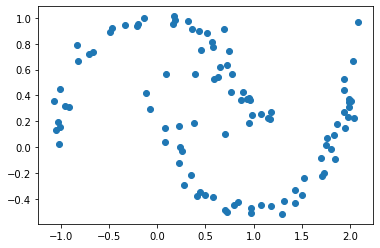

In [12]:
import matplotlib.pyplot as plt
with torch.no_grad():
  plt.scatter(samples[:, 0], samples[:, 1])

#Design cINN
Design our own cINN.

In [ ]:
import torch
import torch.nn as nn
import torch.optim

import FrEIA.framework as Ff
import FrEIA.modules as Fm


class CondNet(nn.Module):
  #TODO
  pass

class MonetCINN(nn.Module):
  def __init__(self, learning_rate):
    super().__init__()

    self.cinn = self.create_cinn()

  def create_cinn(self):
    
    def subnet_conv(hidden_channels_1, hidden_channels_2, kernel_size):
      padding = kernel_size // 2
      return lambda in_channels, out_channels: nn.Sequential(
          nn.Conv2d(in_channels, hidden_channels_1, kernel_size, padding=padding),
          nn.ReLU(),
          nn.Conv2d(hidden_channels_1, hidden_channels_2, kernel_size, padding=padding),
          nn.ReLU(),
          nn.BatchNorm2d(hidden_channels_2),
          nn.Conv2d(hidden_channels_2, out_channels, kernel_size, padding=padding)
      )